Mike Hua

CYPLAN 255: Urban Informatics and Data Visualization

Assignment 4 (Final Project Exploration)

Spring 2022

# Description

I'm hoping to use data from a crosswalk audit that Marcel Moran (Berkeley DCRP Ph.D Student) conducted in San Francisco and published in February. Marcel looked at all intersections in SF and recorded whether a crosswalk existed or not. I am looking at a few possibilites for data sets to analyze alongside this data, including census demographic data, open SF data, and traffic collision data from SafeTREC at UC Berkeley. 

In this initial exploration, I look perform preliminary mapping of the crosswalk audit data as well as explore the speed limit data available from Data SF's API to see what open datasets might be useful to analyze on top of the crosswalk data.

### Crosswalk Data

In [61]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import geopandas as gpd
import json    
import requests
import pprint
pp = pprint.PrettyPrinter
from shapely.geometry import shape
import shapely.geometry
import plotly.figure_factory as ff
import plotly.express as px


In [3]:
cw_raw = pd.read_csv('data/moran_crosswalks_sf-1.csv')
cw = gpd.GeoDataFrame(cw_raw, geometry=gpd.points_from_xy(cw_raw.longitude, cw_raw.latitude))
cw.crs = 'epsg:4326'
cw.head()

,the_geom,cartodb_id,longitude,latitude,cw_q,geometry
0,0101000020E6100000883144A9189B5EC09FE2DD36F8E0...,1,-122.423380,37.757575,True,POINT (-122.42338 37.75757)
1,0101000020E6100000E8FE452BD29D5EC0B3BC619115E1...,2,-122.465953,37.758471,True,POINT (-122.46595 37.75847)
2,0101000020E61000004E2BE0F9A09C5EC0BBEB110FCDE2...,3,-122.447325,37.771883,True,POINT (-122.44733 37.77188)
3,0101000020E610000081D7C2876D9C5EC05435E61A0BE2...,4,-122.444185,37.765964,True,POINT (-122.44419 37.76596)
4,0101000020E610000088A29B583BA05EC0CE8360FA03E3...,5,-122.503622,37.773559,True,POINT (-122.50362 37.77356)


<AxesSubplot:>

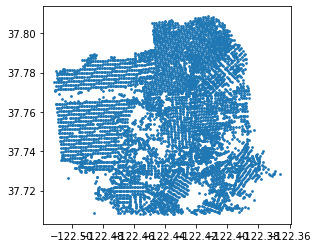

In [4]:
# all crossings in the crosswalk audit data
cw.plot(markersize=3)

In [5]:
cw.groupby(['cw_q']).count().geometry

cw_q
False    2700
True     3732
Name: geometry, dtype: int64

In [6]:
districts = gpd.read_file('https://data.sfgov.org/api/geospatial/keex-zmn4?method=export&format=Shapefile')
districts.head()
districts = districts.to_crs(4326)


In [7]:
dfsjoin = gpd.sjoin(districts, cw) #Spatial join Points to polygons
dfsjoin['cw_q'] = dfsjoin['cw_q'].map({True: 'yes_cw', False: 'no_cw'})
dfsjoin

,supname,supdist,supdistpad,supervisor,numbertext,geometry,index_right,the_geom,cartodb_id,longitude,latitude,cw_q
0,Fewer,SUPERVISORIAL DISTRICT 1,01,1.0,ONE,"POLYGON ((-122.49374 37.78761, -122.49367 37.7...",8,0101000020E6100000ABD3DC651AA05EC0E95D616644E3...,9,-122.501611,37.775525,yes_cw
0,Fewer,SUPERVISORIAL DISTRICT 1,01,1.0,ONE,"POLYGON ((-122.49374 37.78761, -122.49367 37.7...",2799,0101000020E6100000736E6EA708A05EC006F7C10146E3...,2790,-122.500528,37.775574,yes_cw
0,Fewer,SUPERVISORIAL DISTRICT 1,01,1.0,ONE,"POLYGON ((-122.49374 37.78761, -122.49367 37.7...",2862,0101000020E6100000757DD580F79F5EC02F6013E346E3...,2853,-122.499481,37.775601,yes_cw
0,Fewer,SUPERVISORIAL DISTRICT 1,01,1.0,ONE,"POLYGON ((-122.49374 37.78761, -122.49367 37.7...",1968,0101000020E61000009016C2C5E59F5EC0C95CD73749E3...,1960,-122.498399,37.775672,yes_cw
0,Fewer,SUPERVISORIAL DISTRICT 1,01,1.0,ONE,"POLYGON ((-122.49374 37.78761, -122.49367 37.7...",1834,0101000020E6100000DB8F6F4AD49F5EC0DA937ECA4AE3...,1826,-122.497332,37.775720,yes_cw
...,...,...,...,...,...,...,...,...,...,...,...,...
10,Safai,SUPERVISORIAL DISTRICT 11,11,11.0,ELEVEN,"POLYGON ((-122.42247 37.71789, -122.42249 37.7...",3732,0101000020E61000006B274A42A29C5EC00C40FE2D5CDB...,3926,-122.447403,37.713751,no_cw
10,Safai,SUPERVISORIAL DISTRICT 11,11,11.0,ELEVEN,"POLYGON ((-122.42247 37.71789, -122.42249 37.7...",5326,0101000020E6100000244AD63CA29C5EC071E7802C5DDB...,5325,-122.447402,37.713781,no_cw
10,Safai,SUPERVISORIAL DISTRICT 11,11,11.0,ELEVEN,"POLYGON ((-122.42247 37.71789, -122.42249 37.7...",2478,0101000020E610000083CE5AC0BA9C5EC057C5652662DB...,2469,-122.448898,37.713933,yes_cw
10,Safai,SUPERVISORIAL DISTRICT 11,11,11.0,ELEVEN,"POLYGON ((-122.42247 37.71789, -122.42249 37.7...",1719,0101000020E61000005E1844FF5F9C5EC0276B922762DB...,1712,-122.443359,37.713933,yes_cw


In [8]:
# Count crosswalks in each district
dfpivot = pd.pivot_table(dfsjoin,index='supdistpad',columns='cw_q',aggfunc={'cw_q':len})
dfpivot.columns = dfpivot.columns.droplevel()
cw_bydist = districts.merge(dfpivot, how='left', on='supdistpad')

# Add percentage columns
cw_bydist['total_cw'] = cw_bydist['yes_cw'] + cw_bydist['no_cw']
cw_bydist['yes_cw_pct'] = cw_bydist['yes_cw'] / cw_bydist['total_cw'] * 100
cw_bydist['no_cw_pct'] = cw_bydist['no_cw'] / cw_bydist['total_cw'] * 100
cw_bydist

,supname,supdist,supdistpad,supervisor,numbertext,geometry,no_cw,yes_cw,total_cw,yes_cw_pct,no_cw_pct
0,Fewer,SUPERVISORIAL DISTRICT 1,01,1.0,ONE,"POLYGON ((-122.49374 37.78761, -122.49367 37.7...",119,336,455,73.846154,26.153846
1,Stefani,SUPERVISORIAL DISTRICT 2,02,2.0,TWO,"POLYGON ((-122.41922 37.80845, -122.41921 37.8...",139,458,597,76.716918,23.283082
2,Peskin,SUPERVISORIAL DISTRICT 3,03,3.0,THREE,"POLYGON ((-122.39198 37.79387, -122.39218 37.7...",113,294,407,72.235872,27.764128
3,Mar,SUPERVISORIAL DISTRICT 4,04,4.0,FOUR,"POLYGON ((-122.47485 37.76179, -122.47496 37.7...",280,277,557,49.730700,50.269300
4,Preston,SUPERVISORIAL DISTRICT 5,05,5.0,FIVE,"POLYGON ((-122.42157 37.78662, -122.42145 37.7...",82,394,476,82.773109,17.226891
5,Haney,SUPERVISORIAL DISTRICT 6,06,6.0,SIX,"MULTIPOLYGON (((-122.39382 37.79374, -122.3931...",82,357,439,81.321185,18.678815
6,Yee,SUPERVISORIAL DISTRICT 7,07,7.0,SEVEN,"POLYGON ((-122.44854 37.75904, -122.44847 37.7...",501,344,845,40.710059,59.289941
7,Mandelman,SUPERVISORIAL DISTRICT 8,08,8.0,EIGHT,"POLYGON ((-122.42327 37.77206, -122.42325 37.7...",283,300,583,51.457976,48.542024
8,Ronen,SUPERVISORIAL DISTRICT 9,09,9.0,NINE,"POLYGON ((-122.41093 37.76941, -122.41088 37.7...",346,317,663,47.812971,52.187029
9,Walton,SUPERVISORIAL DISTRICT 10,10,10.0,TEN,"MULTIPOLYGON (((-122.39905 37.76973, -122.3981...",371,417,788,52.918782,47.081218


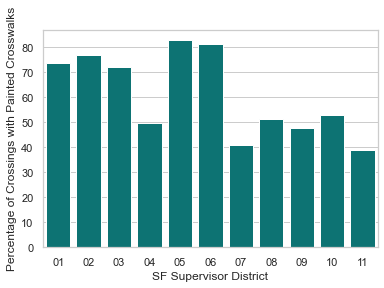

In [9]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="supdistpad", y="yes_cw_pct", data=cw_bydist, color="teal", saturation=.8)
ax.set(xlabel='SF Supervisor District', ylabel='Percentage of Crossings with Painted Crosswalks')
plt.show()

<AxesSubplot:>

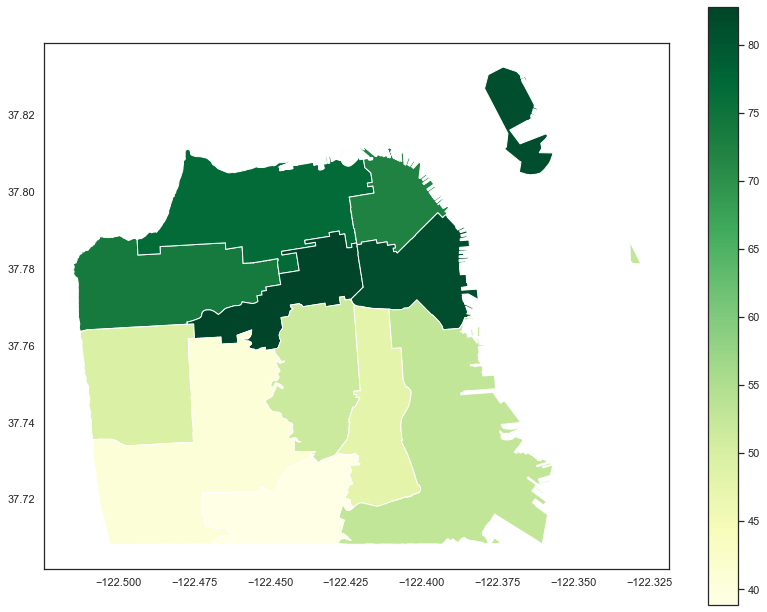

In [54]:
# Map the Percentage of Crossings with Painted Crosswalks by SF Supervisor District
sns.set_style("white")
cw_bydist.plot(column = 'yes_cw_pct',cmap='YlGn', figsize=(14,11), legend=True)

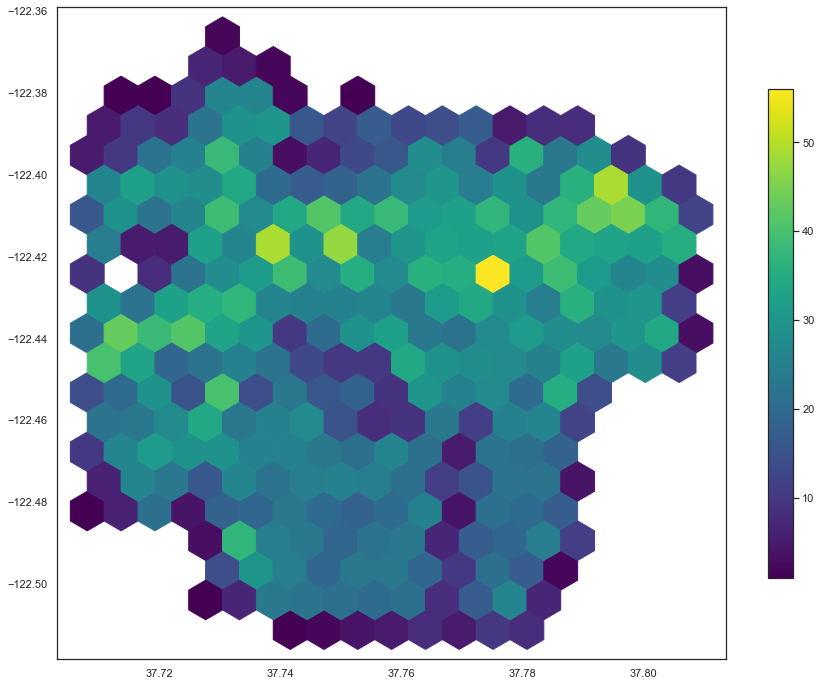

In [12]:
# hex plot of crossing density
# I hope to work on this more to get proportions of marked vs. unmarked crossings in hexbins
#   - basically the previous map but with hexbins instead of supervisor districts

# sns.set_style("white")
# fig, ax = plt.subplots(figsize=(15,12))
# # g = districts.plot(color='none', edgecolor='k', linewidth=.25, ax=ax)
# hb = ax.hexbin(x=cw.latitude, y=cw.longitude, gridsize=18, mincnt=1, cmap='viridis')
# fig.colorbar(hb, shrink=.75, ax=ax)

In [48]:
# px.set_mapbox_access_token(open("mapbox_api_key.json").read())

fig = ff.create_hexbin_mapbox(
    data_frame=cw, lat="latitude", lon="longitude",
    nx_hexagon=10, opacity=0.5, labels={"color": "Proportion Marked Crosswalks"},
    color="cw_q", agg_func=np.mean, color_continuous_scale="plasma",
    min_count=5,
    # show_original_data=True,
    # original_data_marker=dict(size=4, opacity=0.6, color="teal"),
)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

### High Injury Network

In [51]:
injnet = gpd.read_file('Data/high-injury-network/vz_hin_2017_single_line.shp')
injnet = injnet.to_crs(4326)
injnet.head()


,OBJECTID,full_stree,geom_Lengt,length,geometry
0,1,01ST ST,647.802140,0.317816,"LINESTRING (-122.39703 37.78933, -122.39657 37..."
1,2,02ND ST,1283.811791,0.629882,"LINESTRING (-122.39770 37.78634, -122.39723 37..."
2,3,03RD ST,10978.937177,3.304565,"MULTILINESTRING ((-122.39594 37.72172, -122.39..."
3,4,04TH ST,2448.167764,1.200415,"MULTILINESTRING ((-122.39191 37.77468, -122.39..."
4,5,05TH ST,1717.277481,0.842597,"LINESTRING (-122.40807 37.78399, -122.40748 37..."


<AxesSubplot:>

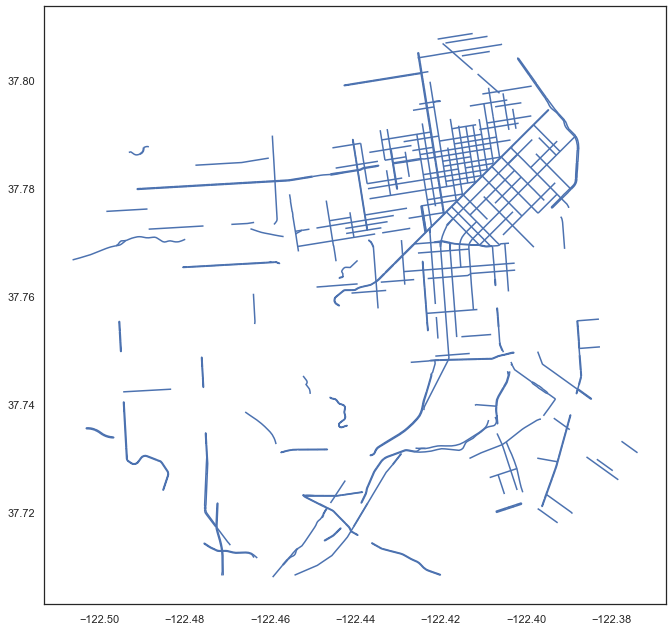

In [55]:
injnet.plot(figsize=(14,11), legend=True)

In [64]:
lats = []
lons = []
names = []

for feature, name in zip(injnet.geometry, injnet.full_stree):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)

fig = px.line_geo(lat=lats, lon=lons, hover_name=names)
fig.update_geos(fitbounds="locations")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

### Speed Limit

In [11]:
# API data

# speed_limit_gj = requests.get('https://data.sfgov.org/resource/3t7b-gebn.geojson') # Speed Limit GEOJSON
speed_lim = pd.read_csv('https://data.sfgov.org/resource/3t7b-gebn.csv') # Speed Limit CSV
speed_lim.head()

,cnn,street,st_type,from_st,to_st,speedlimit,schoolzone,schoolzone_limit,mtab_date,mtab_motion,mtab_reso_text,status,workorder,shape
0,0.0,NaN,NaN,NaN,NaN,15,YES,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-122.412186 37.75583, -122.4..."
1,110000.0,01ST,ST,CLEMENTINA ST,FOLSOM ST,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-122.395 37.787712, -122.394..."
2,112000.0,01ST,ST,GUY PL,LANSING ST,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-122.393906 37.786846, -122...."
3,109000.0,01ST,ST,TENNY PL,CLEMENTINA ST,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-122.39541 37.78804, -122.39..."
4,107000.0,01ST,ST,HOWARD ST,TEHAMA ST,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-122.39602 37.788532, -122.3..."


In [12]:
speed_lim['speedlimit'].unique()

array([15, 25,  0, 30, 35])

In [13]:
# remove rows with 0 speed limit
speed_lim = speed_lim[speed_lim['speedlimit'] != 0]


In [14]:
# remove rows with NaN Street Name
speed_lim = speed_lim[speed_lim['street'].notna()]

In [60]:
sl_hist = speed_lim.groupby(['speedlimit']).count().cnn
sl_hist

speedlimit
15    119
25    256
30     56
35      7
Name: cnn, dtype: int64

In [62]:
speed_lim.groupby(['schoolzone']).mean().speedlimit

schoolzone
YES    15.0
Name: speedlimit, dtype: float64

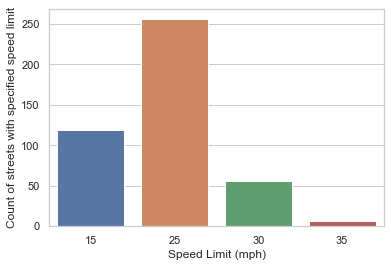

In [30]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = sl_hist.index, y = sl_hist.values)
ax.set(xlabel='Speed Limit (mph)', ylabel='Count of streets with specified speed limit')
plt.show()

## Analysis

From my initial analysis of the crosswalk audit data, its clear that there are spatial disparities in marked crosswalks. As seen in the mapping by supervisor district, intersections in the southern part of SF are much less likely to have painted crosswalks. The disparity by supervisor district might also allude to differences in political power of districts to get infrastructure improvements, but further analysis would be needed there. I hope to further build on this map and make a hexbin version showing how the proportion of marked crosswalks changes across the city in even hexagon zones.

The speed limit data shows a range of speed limits from 15 to 35 miles an hour in the city. All streets with a 15 mph speed limit are in school zones. The likelihood of injury in auto collisions decreases significantly when cars travel at 15 mph versus 25. Diving further into these two data sets can show a need for improved safety interventions at certain intersections such as painting crosswalks and reducing speed limits in non-school zones.

## Research Plan

I want to investigate the disparities in crosswalk quality and whether areas in SF with worse crosswalks have higher pedestrian injury rates. 

I will create maps overlaying poor crosswalks with the high injury network and collision hotspots. I intend to look at whether lack of crosswalks is associated with other pedestrian dangers like high speed limits or poor pedestrian infrastructure like lack of curb ramps and narrow sidewalks. I want to explore a regression discontinuity analysis of crosswalk quality and supervisor district borders to see if political boundaries are associated with crosswalk disparity. Another avenue of exploration would be in accessible infrastructure. By combining the crosswalk data with information on where curb ramps are available in the city, I can illustrate where intersections without crosswalks and curb ramps might create large access barriers for folks.

I intend to use my analysis to advocate for safer pedestrian environments in SF. The analysis of combined datasets can help show intersections with the poorest infrastructure, which can help community organizations push for change and help SFMTA and SF Public Works prioritize improvements.

I will use infrastructure datasets from Data SF and SWITRS injury data from UC Berkeley SafeTREC. Most of my work will be mapping using geopandas and matplotlib. I might explore PySAL for more advanced spatial analysis techniques.